#### <h1>The Multi-layered Perceptron Neural Collaborative Filtering (MLP-NCF) proposed model training</h1>

<h2>Import necessary python library for model training</h2>

In [1]:
import zipfile
from zipfile import ZipFile
from torch.utils.data import Dataset, DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import os
import pandas as pd
import numpy as np
import requests
import sklearn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
import time
import argparse
import matplotlib.pyplot as plt

<h2>The data preparation for training class</h2>

In [2]:
class MovieLens(Dataset):
    def __init__(self, df: pd.DataFrame, total_df: pd.DataFrame, ng_ratio:int)->None:
        '''
        : param df: training dataframe
        : param total_df: the entire dataframe
        : param ng_ratio: negative sampling ratio
        '''
        super(MovieLens, self).__init__()

        self.df = df
        self.total_df = total_df
        self.ng_ratio = ng_ratio
        self.users, self.items, self.labels = self._negative_sampling()

    def __len__(self) -> int:
        '''
        get length of data
        : return: len(data)
        '''
        return len(self.users)

    def __getitem__(self, index):
        '''
        transform userId[index], item[index] to Tensor and return to Datalaoder object.
        : param index: index for dataset.
        : return: user, item, rating
        '''
        return self.users[index], self.items[index], self.labels[index]

    def _negative_sampling(self) :
        '''
        sampling one positive feedback per #(ng ratio) negative feedback
        : return: list of users, list of items, list of targets
        '''
        df = self.df
        total_df = self.total_df
        users, items, labels = [], [], []
        user_item_set = set(zip(df['userId'], df['movieId']))
        total_user_item_set = set(zip(total_df['userId'],total_df['movieId']))
        all_movieIds = total_df['movieId'].unique()
        
        # negative feedback dataset ratio
        negative_ratio = self.ng_ratio
        for u, i in user_item_set:
            # positive instance
            users.append(u)
            items.append(i)
            labels.append(1.0)

            #visited check
            visited=[]
            visited.append(i)
            
            # negative instance
            for i in range(negative_ratio):
                # first item random choice
                negative_item = np.random.choice(all_movieIds)
 
                # check if item and user has interaction, if true then set new value from random
                while (u, negative_item) in total_user_item_set or negative_item in visited :
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                visited.append(negative_item)
                labels.append(0.0)
        print(f"negative sampled data: {len(labels)}")
        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

<h2>The Multi-layered perceptron neural collaborative filtering (NCF) model</h2>

In [3]:
class MLP(nn.Module):
    def __init__(self, num_users, num_items, embedding_size, layer_dims, use_NeuMF=False):
        super(MLP, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.item_embedding = nn.Embedding(num_items, embedding_size)
        
        # Calculate input dimension for first layer
        first_layer_input = embedding_size * 2  # Concatenated user and item embeddings
        
        # Build MLP layers dynamically
        layers = []
        input_dim = first_layer_input
        for output_dim in layer_dims:
            layers.append(nn.Linear(input_dim, output_dim))
            layers.append(nn.ReLU())
            input_dim = output_dim
        
        self.mlp_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(layer_dims[-1], 1)
        self.sigmoid = nn.Sigmoid()
        self._init_weights()

    def _init_weights(self):
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)
        for layer in self.mlp_layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        x = torch.cat([user_emb, item_emb], dim=-1)
        x = self.mlp_layers(x)
        x = self.output_layer(x)
        return self.sigmoid(x).view(-1)

<h2>Evaluation Metrics</h2>

In [4]:
def hit(gt_item, pred_items):
	if gt_item in pred_items:
		return 1
	return 0

def ndcg(gt_item, pred_items):
	if gt_item in pred_items:
		index = pred_items.index(gt_item)
		return np.reciprocal(np.log2(index+2))
	return 0

def metrics(model, data_loader, top_k, device):
	HR, NDCG = [], []

	for user, item, label in data_loader:

		user = user.to(device)
		item = item.to(device)

		predictions = model(user, item)
		_, indices = torch.topk(predictions, top_k)

		recommends = torch.take(
				item, indices).cpu().numpy().tolist()

		gt_item = item[0].item()
		HR.append(hit(gt_item, recommends))
		NDCG.append(ndcg(gt_item, recommends))

	return np.mean(HR), np.mean(NDCG)

<h2>Model training class</h2>

In [5]:
class Train():
    def __init__(self, model: torch.nn.Module,
                 optimizer: torch.optim,
                 epochs: int,
                 dataloader: torch.utils.data.dataloader,
                 criterion: torch.nn,
                 test_obj: torch.utils.data.dataloader,
                 device: str = 'cuda',
                 print_cost: bool = True,
                 top_k: int = 10):
        self.model = model
        self.optimizer = optimizer
        self.epochs = epochs
        self.dataloader = dataloader
        self.criterion = criterion
        self.device = device
        self.print_cost = print_cost
        self.test = test_obj
        self.top_k = top_k

    def train(self):
        model = self.model
        optimizer = self.optimizer
        total_epochs = self.epochs
        dataloader = self.dataloader
        criterion = self.criterion
        total_batch = len(dataloader)
        loss = []
        device = self.device
        test_dataloader = self.test

        hr_list = []
        ndcg_list = []
        test_loss_list = []

        for epoch in range(0, total_epochs):
            epoch_loss = 0
            with tqdm(total=len(dataloader), desc=f'Epoch {epoch + 1}/{total_epochs}', unit='batch') as pbar:
                for user, item, target in dataloader:
                    user, item, target = user.to(device), item.to(device), target.float().to(device)
                    optimizer.zero_grad()
                    pred = model(user, item)
                    cost = criterion(pred, target)
                    cost.backward()
                    optimizer.step()
                    epoch_loss += cost.item()
                    pbar.update(1)
                    pbar.set_postfix({'loss': cost.item()})

            avg_epoch_loss = epoch_loss / total_batch
            loss.append(avg_epoch_loss)

            if self.print_cost:
                HR, NDCG = metrics(model, self.test, self.top_k, device)

                model.eval()
                test_loss = 0
                with torch.no_grad():
                    for user, item, target in test_dataloader:
                        user, item, target = user.to(device), item.to(device), target.float().to(device)
                        pred = model(user, item)
                        cost = criterion(pred, target)
                        test_loss += cost.item()
                avg_test_loss = test_loss / len(test_dataloader)
                model.train()

                print(
                    "Epochs: {}\tAvg Train Loss: {:.4f}\tAvg Test Loss: {:.4f}\tHR: {:.3f}\tNDCG: {:.3f}".format(
                        epoch+1, avg_epoch_loss, avg_test_loss, np.mean(HR), np.mean(NDCG)))

                hr_list.append(np.mean(HR))
                ndcg_list.append(np.mean(NDCG))
                test_loss_list.append(avg_test_loss)

        if self.print_cost:
            print('Learning finished')
        return loss, test_loss_list, hr_list, ndcg_list

In [6]:
def plot_comparison_metrics(train_loss_1, test_loss_list_1, hr_list_1, ndcg_list_1,
                           train_loss_4, test_loss_list_4, hr_list_4, ndcg_list_4, top_k):
    epochs = np.arange(1, len(train_loss_1) + 1)

    output_dir = './Training Results/'
    os.makedirs(output_dir, exist_ok=True)

    # Create a single figure with 4 subplots
    plt.figure(figsize=(16, 12))
    
    # Plot Training Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss_1, label='Dataset 1', marker='o')
    plt.plot(epochs, train_loss_4, label='Dataset 2', marker='x')
    plt.title('Training Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Plot Test Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, test_loss_list_1, label='Dataset 1', marker='o')
    plt.plot(epochs, test_loss_list_4, label='Dataset 2', marker='x')
    plt.title('Test Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Plot HR@10
    plt.subplot(2, 2, 3)
    plt.plot(epochs, hr_list_1, label='Dataset 1', marker='o')
    plt.plot(epochs, hr_list_4, label='Dataset 2', marker='x')
    plt.title(f'Hit Ratio @ {top_k} Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Plot NDCG@10
    plt.subplot(2, 2, 4)
    plt.plot(epochs, ndcg_list_1, label='Dataset 1', marker='o')
    plt.plot(epochs, ndcg_list_4, label='Dataset 2', marker='x')
    plt.title(f'NDCG @ {top_k} Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Add main title and adjust layout
    plt.suptitle('Model 2 Performance Comparison on Dataset 1 and Dataset 2', fontsize=16, y=1.02)
    plt.tight_layout()
    
    # Save the entire figure
    plt.savefig(os.path.join(output_dir, f'ncf_performance_comparison_top_{top_k}_D1D2_M2.png'), 
                bbox_inches='tight', dpi=300)
    plt.show()

<h2>Putting everything together</h2>

In [8]:
import pandas as pd
import torch
import argparse
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import numpy as np
import time

start_time = time.time()  # Record start time

# check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

# print GPU information
if torch.cuda.is_available():
    print('Current cuda device:', torch.cuda.current_device())
    print('Count of using GPUs:', torch.cuda.device_count())

# directory to save checkpoints
pretrain_dir = 'ncf_models'
if not os.path.isdir(pretrain_dir):
    os.makedirs(pretrain_dir)

# the train, test and total dataset
train_df_1 = pd.read_csv("./Datasets/train_D1.csv")
test_df_1 = pd.read_csv("./Datasets/test_D1.csv")
total_df_1 = pd.read_csv("./Datasets/ratings_preprocessed_D1.csv")

train_df_4 = pd.read_csv("./Datasets/train_D2.csv")
test_df_4 = pd.read_csv("./Datasets/test_D2.csv")
total_df_4 = pd.read_csv("./Datasets/ratings_preprocessed_D2.csv")

# make torch.utils.data.Data object
train_set_1 = MovieLens(df=train_df_1, total_df=total_df_1, ng_ratio=3)
test_set_1 = MovieLens(df=test_df_1, total_df=total_df_1, ng_ratio=99)

train_set_4 = MovieLens(df=train_df_4, total_df=total_df_4, ng_ratio=3)
test_set_4 = MovieLens(df=test_df_4, total_df=total_df_4, ng_ratio=99)

# Find Global Maximums
max_num_users_global = max(total_df_1['userId'].max(), total_df_4['userId'].max()) + 1  #, total_df_2['userId'].max()
max_num_items_global = max(total_df_1['movieId'].max(), total_df_4['movieId'].max()) + 1  #, total_df_2['movieId'].max()

print('data loaded!')

# dataloader for train_dataset
dataloader_train_1 = DataLoader(dataset=train_set_1, batch_size=256, shuffle=True, num_workers=0)

# dataloader for test_dataset
dataloader_test_1 = DataLoader(dataset=test_set_1, batch_size=100, shuffle=False, num_workers=0, drop_last=True)

# dataloader for train_dataset
dataloader_train_4 = DataLoader(dataset=train_set_4, batch_size=256, shuffle=True, num_workers=0)

# dataloader for test_dataset
dataloader_test_4 = DataLoader(dataset=test_set_4, batch_size=100, shuffle=False, num_workers=0, drop_last=True)

model = MLP(num_users=max_num_users_global, num_items=max_num_items_global, embedding_size=16, layer_dims=[32,16,8], use_NeuMF=False) #emb size, layer

# Initialize optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.005) #learning rate

# objective function is log loss (Cross-entropy loss)
criterion = torch.nn.BCELoss()

model.to(device)
save_model = True

end_time = time.time()    # Record end time
training_time = end_time - start_time  # Calculate training time
print(f"Training time: {training_time:.5f}")  # Print the training time

device: cpu
negative sampled data: 400684
negative sampled data: 61000
negative sampled data: 3976676
negative sampled data: 604000
data loaded!
Training time: 123.27951


<h2>Dataset 1 Model Training</h2>

In [10]:
# Initialize trainer with customizable top_k

trainer_1 = Train(model=model,
              optimizer=optimizer,
              criterion=criterion,
              epochs=15,
              test_obj=dataloader_test_1,
              dataloader=dataloader_train_1,
              device=device,
              print_cost=True,
              top_k=10)
    
# measuring time
start = time.time()
loss_1, test_loss_list_1, hr_list_1, ndcg_list_1 = trainer_1.train()

end = time.time()

time_message = f'Training time: {end-start:.5f} seconds'
print(time_message)

Epoch 1/15: 100%|███████████████████████████████████████████████████| 1566/1566 [00:57<00:00, 27.44batch/s, loss=0.289]


Epochs: 1	Avg Train Loss: 0.4061	Avg Test Loss: 0.1931	HR: 0.572	NDCG: 0.320


Epoch 2/15: 100%|████████████████████████████████████████████████████| 1566/1566 [00:59<00:00, 26.50batch/s, loss=0.36]


Epochs: 2	Avg Train Loss: 0.3307	Avg Test Loss: 0.1899	HR: 0.595	NDCG: 0.345


Epoch 3/15: 100%|███████████████████████████████████████████████████| 1566/1566 [00:58<00:00, 26.82batch/s, loss=0.319]


Epochs: 3	Avg Train Loss: 0.2955	Avg Test Loss: 0.1995	HR: 0.611	NDCG: 0.360


Epoch 4/15: 100%|████████████████████████████████████████████████████| 1566/1566 [00:58<00:00, 26.85batch/s, loss=0.29]


Epochs: 4	Avg Train Loss: 0.2694	Avg Test Loss: 0.1996	HR: 0.623	NDCG: 0.369


Epoch 5/15: 100%|███████████████████████████████████████████████████| 1566/1566 [00:59<00:00, 26.29batch/s, loss=0.231]


Epochs: 5	Avg Train Loss: 0.2506	Avg Test Loss: 0.2029	HR: 0.634	NDCG: 0.373


Epoch 6/15: 100%|███████████████████████████████████████████████████| 1566/1566 [00:59<00:00, 26.18batch/s, loss=0.184]


Epochs: 6	Avg Train Loss: 0.2370	Avg Test Loss: 0.1793	HR: 0.625	NDCG: 0.371


Epoch 7/15: 100%|███████████████████████████████████████████████████| 1566/1566 [00:59<00:00, 26.52batch/s, loss=0.261]


Epochs: 7	Avg Train Loss: 0.2265	Avg Test Loss: 0.2056	HR: 0.628	NDCG: 0.364


Epoch 8/15: 100%|███████████████████████████████████████████████████| 1566/1566 [00:58<00:00, 26.82batch/s, loss=0.149]


Epochs: 8	Avg Train Loss: 0.2183	Avg Test Loss: 0.2269	HR: 0.626	NDCG: 0.370


Epoch 9/15: 100%|███████████████████████████████████████████████████| 1566/1566 [00:57<00:00, 27.04batch/s, loss=0.175]


Epochs: 9	Avg Train Loss: 0.2115	Avg Test Loss: 0.2002	HR: 0.610	NDCG: 0.359


Epoch 10/15: 100%|██████████████████████████████████████████████████| 1566/1566 [00:55<00:00, 28.19batch/s, loss=0.163]


Epochs: 10	Avg Train Loss: 0.2057	Avg Test Loss: 0.2348	HR: 0.628	NDCG: 0.365


Epoch 11/15: 100%|██████████████████████████████████████████████████| 1566/1566 [00:57<00:00, 27.42batch/s, loss=0.124]


Epochs: 11	Avg Train Loss: 0.1996	Avg Test Loss: 0.2040	HR: 0.610	NDCG: 0.354


Epoch 12/15: 100%|██████████████████████████████████████████████████| 1566/1566 [00:55<00:00, 28.30batch/s, loss=0.178]


Epochs: 12	Avg Train Loss: 0.1955	Avg Test Loss: 0.2331	HR: 0.611	NDCG: 0.344


Epoch 13/15: 100%|██████████████████████████████████████████████████| 1566/1566 [00:56<00:00, 27.76batch/s, loss=0.272]


Epochs: 13	Avg Train Loss: 0.1910	Avg Test Loss: 0.2638	HR: 0.616	NDCG: 0.348


Epoch 14/15: 100%|██████████████████████████████████████████████████| 1566/1566 [00:56<00:00, 27.56batch/s, loss=0.292]


Epochs: 14	Avg Train Loss: 0.1882	Avg Test Loss: 0.2758	HR: 0.621	NDCG: 0.353


Epoch 15/15: 100%|██████████████████████████████████████████████████| 1566/1566 [00:56<00:00, 27.58batch/s, loss=0.161]


Epochs: 15	Avg Train Loss: 0.1842	Avg Test Loss: 0.2611	HR: 0.618	NDCG: 0.350
Learning finished
Training time: 913.13465 seconds


<h2>Dataset 4 Model Training</h2>

In [9]:
# Initialize trainer with customizable top_k

trainer_2 = Train(model=model,
              optimizer=optimizer,
              criterion=criterion,
              epochs=15,
              test_obj=dataloader_test_4,
              dataloader=dataloader_train_4,
              device=device,
              print_cost=True,
              top_k=10)
    
# measuring time
start = time.time()
loss_4, test_loss_list_4, hr_list_4, ndcg_list_4 = trainer_2.train()

end = time.time()

time_message = f'Training time: {end-start:.5f} seconds'
print(time_message)

Epoch 1/15: 100%|█████████████████████████████████████████████████| 15534/15534 [09:09<00:00, 28.28batch/s, loss=0.319]


Epochs: 1	Avg Train Loss: 0.3841	Avg Test Loss: 0.2140	HR: 0.513	NDCG: 0.285


Epoch 2/15: 100%|█████████████████████████████████████████████████| 15534/15534 [09:04<00:00, 28.51batch/s, loss=0.283]


Epochs: 2	Avg Train Loss: 0.3395	Avg Test Loss: 0.2006	HR: 0.575	NDCG: 0.322


Epoch 3/15: 100%|█████████████████████████████████████████████████| 15534/15534 [09:27<00:00, 27.36batch/s, loss=0.302]


Epochs: 3	Avg Train Loss: 0.3191	Avg Test Loss: 0.2076	HR: 0.595	NDCG: 0.336


Epoch 4/15: 100%|█████████████████████████████████████████████████| 15534/15534 [09:21<00:00, 27.66batch/s, loss=0.316]


Epochs: 4	Avg Train Loss: 0.3100	Avg Test Loss: 0.1865	HR: 0.606	NDCG: 0.346


Epoch 5/15: 100%|█████████████████████████████████████████████████| 15534/15534 [09:25<00:00, 27.48batch/s, loss=0.336]


Epochs: 5	Avg Train Loss: 0.3030	Avg Test Loss: 0.1925	HR: 0.610	NDCG: 0.348


Epoch 6/15: 100%|█████████████████████████████████████████████████| 15534/15534 [09:20<00:00, 27.72batch/s, loss=0.272]


Epochs: 6	Avg Train Loss: 0.2970	Avg Test Loss: 0.1805	HR: 0.627	NDCG: 0.357


Epoch 7/15: 100%|█████████████████████████████████████████████████| 15534/15534 [09:30<00:00, 27.22batch/s, loss=0.263]


Epochs: 7	Avg Train Loss: 0.2924	Avg Test Loss: 0.1881	HR: 0.620	NDCG: 0.355


Epoch 8/15: 100%|█████████████████████████████████████████████████| 15534/15534 [09:37<00:00, 26.89batch/s, loss=0.287]


Epochs: 8	Avg Train Loss: 0.2888	Avg Test Loss: 0.1838	HR: 0.629	NDCG: 0.361


Epoch 9/15: 100%|█████████████████████████████████████████████████| 15534/15534 [09:38<00:00, 26.85batch/s, loss=0.333]


Epochs: 9	Avg Train Loss: 0.2860	Avg Test Loss: 0.1919	HR: 0.637	NDCG: 0.365


Epoch 10/15: 100%|████████████████████████████████████████████████| 15534/15534 [09:49<00:00, 26.33batch/s, loss=0.246]


Epochs: 10	Avg Train Loss: 0.2838	Avg Test Loss: 0.1734	HR: 0.637	NDCG: 0.365


Epoch 11/15: 100%|████████████████████████████████████████████████| 15534/15534 [10:01<00:00, 25.84batch/s, loss=0.339]


Epochs: 11	Avg Train Loss: 0.2819	Avg Test Loss: 0.1901	HR: 0.636	NDCG: 0.366


Epoch 12/15: 100%|████████████████████████████████████████████████| 15534/15534 [09:45<00:00, 26.54batch/s, loss=0.267]


Epochs: 12	Avg Train Loss: 0.2803	Avg Test Loss: 0.1881	HR: 0.636	NDCG: 0.369


Epoch 13/15: 100%|████████████████████████████████████████████████| 15534/15534 [09:45<00:00, 26.53batch/s, loss=0.241]


Epochs: 13	Avg Train Loss: 0.2791	Avg Test Loss: 0.1654	HR: 0.635	NDCG: 0.366


Epoch 14/15: 100%|████████████████████████████████████████████████| 15534/15534 [09:43<00:00, 26.60batch/s, loss=0.309]


Epochs: 14	Avg Train Loss: 0.2778	Avg Test Loss: 0.1798	HR: 0.644	NDCG: 0.374


Epoch 15/15: 100%|████████████████████████████████████████████████| 15534/15534 [09:36<00:00, 26.93batch/s, loss=0.284]


Epochs: 15	Avg Train Loss: 0.2768	Avg Test Loss: 0.2042	HR: 0.640	NDCG: 0.367
Learning finished
Training time: 9068.87826 seconds


<h2>Plotting Graphs</h2>

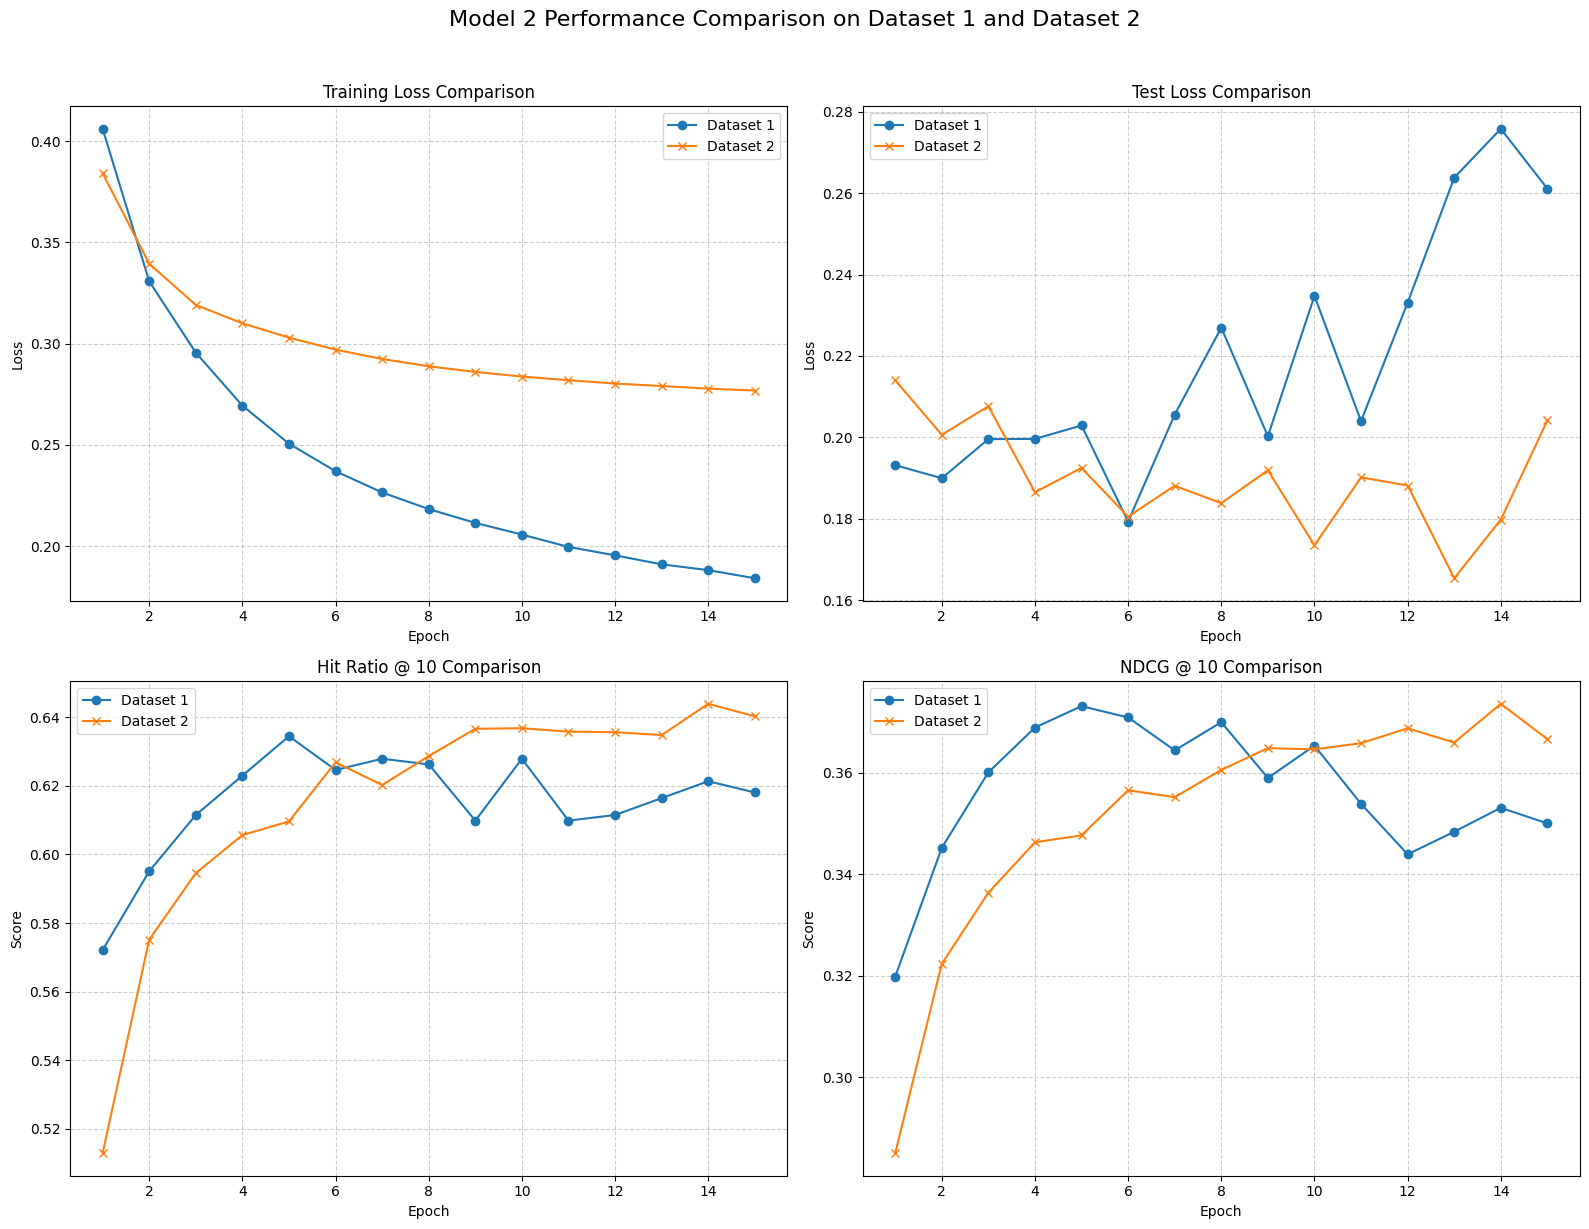

In [11]:
plot_comparison_metrics(loss_1, test_loss_list_1, hr_list_1, ndcg_list_1, loss_4, test_loss_list_4, hr_list_4, ndcg_list_4, top_k=trainer_2.top_k)

In [12]:
model

MLP(
  (user_embedding): Embedding(6041, 16)
  (item_embedding): Embedding(193610, 16)
  (mlp_layers): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
  )
  (output_layer): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

<h2>Inference Checking</h2>

<h3>Getting inference with corresponding metrics from a test set</h3>

In [13]:
def metrics_with_recommendations_with_titles(model, test_loader, top_k, total_dataframe, device):
    """
    Function to return recommendations with metrics and predicted scores.

    Parameters:
    -----------
    model: The trained model checkpoints
    test_loader: The test data loader
    top_k: Total numbers of movies to recommend
    total_dataframe: The total dataframe to map the id of the movie with title
    device: According to availability CPU or a GPU

    Returns:
    ---------
    HR: The Hit rate metrics
    NDCG: The NDCG metrics
    all_recommendations: The top_k recommended movies with titles and predicted scores
    """
    HR, NDCG, all_recommendations = [], [], []

    for user, item, label in test_loader:
        user = user.to(device)
        item = item.to(device)

        predictions = model(user, item)
        # Get top-k predictions and their indices
        top_k_scores, top_k_indices = torch.topk(predictions, top_k)

        # Convert to lists
        recommends = torch.take(item, top_k_indices).cpu().numpy().tolist()
        recommend_scores = top_k_scores.cpu().detach().numpy().tolist()

        # Ground truth item
        gt_item = item[0].item()
        HR.append(hit(gt_item, recommends))
        NDCG.append(ndcg(gt_item, recommends))

        # Get movie titles and scores for the recommended movies
        recommended_movies = []
        for rec, score in zip(recommends, recommend_scores):
            title = total_dataframe[total_dataframe['movieId'] == rec]['title'].values[0]
            recommended_movies.append({
                'movieId': rec,
                'title': title,
                'score': float(score)  # Convert numpy float to Python float for JSON compatibility
            })

        all_recommendations.append({
            'user': user[0].item() if user.numel() == 1 else user.tolist()[0],  # Ensure single user per batch
            'ground_truth': {
                'movieId': gt_item,
                'title': total_dataframe[total_dataframe['movieId'] == gt_item]['title'].values[0]
            },
            'recommendations': recommended_movies
        })

    return np.mean(HR), np.mean(NDCG), all_recommendations

# main HERE
k = 10 # change the value of k here

HR, NDCG, all_recommendations = metrics_with_recommendations_with_titles(
    model, 
    test_loader=dataloader_test_1, 
    top_k=k,
    total_dataframe=total_df_1, 
    device=device
)

# Print metrics
print(f"Evaluation Metrics:")
print(f"HR@{k}: {HR:.3f}")
print(f"NDCG@{k}: {NDCG:.3f}")

# Print recommendations with scores (for the first user)
first_user_rec = all_recommendations[0]
print(f"\nUser: {first_user_rec['user']}")
print(f"Ground Truth: {first_user_rec['ground_truth']['title']} (MovieID: {first_user_rec['ground_truth']['movieId']})")
print(f"\nTop {k} Recommendations for User {first_user_rec['user']}:") # attention HERE
for idx, rec in enumerate(first_user_rec['recommendations'], 1):
    print(f"{idx}. {rec['title']} (MovieID: {rec['movieId']}, Score: {rec['score']:.3f})")

Evaluation Metrics:
HR@10: 0.618
NDCG@10: 0.350

User: 31
Ground Truth: Pallbearer, The (1996) (MovieID: 612)

Top 10 Recommendations for User 31:
1. Batman (1989) (MovieID: 592, Score: 0.982)
2. Star Wars: Episode IV - A New Hope (1977) (MovieID: 260, Score: 0.965)
3. Blazing Saddles (1974) (MovieID: 3671, Score: 0.936)
4. Raising Arizona (1987) (MovieID: 1394, Score: 0.826)
5. Gattaca (1997) (MovieID: 1653, Score: 0.822)
6. 12 Angry Men (1957) (MovieID: 1203, Score: 0.717)
7. Rocky (1976) (MovieID: 1954, Score: 0.528)
8. Thelma & Louise (1991) (MovieID: 3418, Score: 0.405)
9. Misérables, Les (1998) (MovieID: 1873, Score: 0.328)
10. Safe (1995) (MovieID: 190, Score: 0.328)


In [14]:
def metrics_with_recommendations_with_titles(model, test_loader, top_k, total_dataframe, device):
    """
    Function to return recommendations with metrics and predicted scores.

    Parameters:
    -----------
    model: The trained model checkpoints
    test_loader: The test data loader
    top_k: Total numbers of movies to recommend
    total_dataframe: The total dataframe to map the id of the movie with title
    device: According to availability CPU or a GPU

    Returns:
    ---------
    HR: The Hit rate metrics
    NDCG: The NDCG metrics
    all_recommendations: The top_k recommended movies with titles and predicted scores
    """
    HR, NDCG, all_recommendations = [], [], []

    for user, item, label in test_loader:
        user = user.to(device)
        item = item.to(device)

        predictions = model(user, item)
        # Get top-k predictions and their indices
        top_k_scores, top_k_indices = torch.topk(predictions, top_k)

        # Convert to lists
        recommends = torch.take(item, top_k_indices).cpu().numpy().tolist()
        recommend_scores = top_k_scores.cpu().detach().numpy().tolist()

        # Ground truth item
        gt_item = item[0].item()
        HR.append(hit(gt_item, recommends))
        NDCG.append(ndcg(gt_item, recommends))

        # Get movie titles and scores for the recommended movies
        recommended_movies = []
        for rec, score in zip(recommends, recommend_scores):
            title = total_dataframe[total_dataframe['movieId'] == rec]['title'].values[0]
            recommended_movies.append({
                'movieId': rec,
                'title': title,
                'score': float(score)  # Convert numpy float to Python float for JSON compatibility
            })

        all_recommendations.append({
            'user': user[0].item() if user.numel() == 1 else user.tolist()[0],  # Ensure single user per batch
            'ground_truth': {
                'movieId': gt_item,
                'title': total_dataframe[total_dataframe['movieId'] == gt_item]['title'].values[0]
            },
            'recommendations': recommended_movies
        })

    return np.mean(HR), np.mean(NDCG), all_recommendations

# main HERE
k = 10 # change the value of k here
HR, NDCG, all_recommendations = metrics_with_recommendations_with_titles(
    model, 
    test_loader=dataloader_test_4, 
    top_k=k, 
    total_dataframe=total_df_4, 
    device=device
)

print(f"Evaluation Metrics:")
print(f"HR@{k}: {HR:.3f}")
print(f"NDCG@{k}: {NDCG:.3f}")

# Print recommendations with scores (for the first user)
first_user_rec = all_recommendations[0]
print(f"\nUser: {first_user_rec['user']}")
print(f"Ground Truth: {first_user_rec['ground_truth']['title']} (MovieID: {first_user_rec['ground_truth']['movieId']})")
print(f"\nTop {k} Recommendations for User {first_user_rec['user']}:") # attention HERE
for idx, rec in enumerate(first_user_rec['recommendations'], 1):
    print(f"{idx}. {rec['title']} (MovieID: {rec['movieId']}, Score: {rec['score']:.3f})")

Evaluation Metrics:
HR@10: 0.452
NDCG@10: 0.237

User: 891
Ground Truth: Devil's Own, The (1997) (MovieID: 1488)

Top 10 Recommendations for User 891:
1. Princess Bride, The (1987) (MovieID: 1197, Score: 0.952)
2. Dogma (1999) (MovieID: 3052, Score: 0.919)
3. Waterworld (1995) (MovieID: 208, Score: 0.917)
4. Sleepless in Seattle (1993) (MovieID: 539, Score: 0.833)
5. Sling Blade (1996) (MovieID: 1358, Score: 0.821)
6. Santa Clause, The (1994) (MovieID: 317, Score: 0.791)
7. Three Musketeers, The (1993) (MovieID: 552, Score: 0.783)
8. Grosse Pointe Blank (1997) (MovieID: 1500, Score: 0.763)
9. Perfect Storm, The (2000) (MovieID: 3755, Score: 0.735)
10. Rear Window (1954) (MovieID: 904, Score: 0.695)


<h3>Getting recommendations for an existing user of the system</h3>

In [15]:
def inference_for_single_user_by_id(model, user_id, top_k, total_dataframe, test_loader, device):
    """
    Function to perform inference for a single user by user ID and return recommendations with metrics.

    Parameters:
    -----------
    model: The trained model checkpoints
    user_id: The ID of the user for whom to make recommendations
    top_k: Total numbers of movies to recommend
    total_dataframe: The total dataframe to map the id of the movie with title
    test_loader: The DataLoader for the test set
    device: According to availability CPU or a GPU

    Returns:
    ---------
    recommendations: Dictionary with user ID, ground truth, and recommended movies with scores
    """
    user_found = False
    
    for user, item, label in test_loader:
        if user[0].item() == user_id:
            user_found = True
            user = user.to(device)
            item = item.to(device)

            print(f"User ID {user_id} found in the test loader.")
            predictions = model(user, item)
            top_k_scores, top_k_indices = torch.topk(predictions, top_k)

            # Convert to lists
            recommends = torch.take(item, top_k_indices).cpu().numpy().tolist()
            recommend_scores = top_k_scores.cpu().detach().numpy().tolist()

            # Get movie details for the recommended movies
            recommended_movies = []
            for rec, score in zip(recommends, recommend_scores):
                title = total_dataframe[total_dataframe['movieId'] == rec]['title'].values[0]
                recommended_movies.append({
                    'movieId': rec,
                    'title': title,
                    'score': float(score)  # Convert numpy float to Python float
                })

            return {
                'user': user[0].item(),
                'recommendations': recommended_movies
            }
    
    if not user_found:
        raise ValueError(f"User ID {user_id} not found in the test loader.")

# Example usage
user_id_to_infer = 1  # Replace with the user ID you want to infer
recommendations = inference_for_single_user_by_id(
    model, 
    user_id_to_infer, 
    top_k=10, 
    total_dataframe=total_df_1, 
    test_loader=dataloader_test_1, 
    device=device
)

# Print recommendations with scores
print(f"\nTop {len(recommendations['recommendations'])} Recommendations for User {recommendations['user']}:")
for idx, rec in enumerate(recommendations['recommendations'], 1):
    print(f"{idx}. {rec['title']} (ID: {rec['movieId']}) | Score: {rec['score']:.3f}")

User ID 1 found in the test loader.

Top 10 Recommendations for User 1:
1. Cliffhanger (1993) (ID: 434) | Score: 0.948
2. Network (1976) (ID: 3504) | Score: 0.914
3. Dirty Dancing (1987) (ID: 1088) | Score: 0.910
4. Muppet Treasure Island (1996) (ID: 107) | Score: 0.873
5. My Life in Pink (Ma vie en rose) (1997) (ID: 1734) | Score: 0.795
6. Any Given Sunday (1999) (ID: 3173) | Score: 0.794
7. Ben-Hur (1959) (ID: 1287) | Score: 0.771
8. Seven Years in Tibet (1997) (ID: 1619) | Score: 0.764
9. Dark City (1998) (ID: 1748) | Score: 0.744
10. My Favorite Year (1982) (ID: 921) | Score: 0.699


In [16]:
def inference_for_single_user_by_id(model, user_id, top_k, total_dataframe, test_loader, device):
    """
    Function to perform inference for a single user by user ID and return recommendations with metrics.

    Parameters:
    -----------
    model: The trained model checkpoints
    user_id: The ID of the user for whom to make recommendations
    top_k: Total numbers of movies to recommend
    total_dataframe: The total dataframe to map the id of the movie with title
    test_loader: The DataLoader for the test set
    device: According to availability CPU or a GPU

    Returns:
    ---------
    recommendations: Dictionary with user ID, ground truth, and recommended movies with scores
    """
    user_found = False
    
    for user, item, label in test_loader:
        if user[0].item() == user_id:
            user_found = True
            user = user.to(device)
            item = item.to(device)

            print(f"User ID {user_id} found in the test loader.")
            predictions = model(user, item)
            top_k_scores, top_k_indices = torch.topk(predictions, top_k)

            # Convert to lists
            recommends = torch.take(item, top_k_indices).cpu().numpy().tolist()
            recommend_scores = top_k_scores.cpu().detach().numpy().tolist()

            # Get movie details for the recommended movies
            recommended_movies = []
            for rec, score in zip(recommends, recommend_scores):
                title = total_dataframe[total_dataframe['movieId'] == rec]['title'].values[0]
                recommended_movies.append({
                    'movieId': rec,
                    'title': title,
                    'score': float(score)  # Convert numpy float to Python float
                })

            return {
                'user': user[0].item(),
                'recommendations': recommended_movies
            }
    
    if not user_found:
        raise ValueError(f"User ID {user_id} not found in the test loader.")

# Example usage
user_id_to_infer = 1  # Replace with the user ID you want to infer
recommendations = inference_for_single_user_by_id(
    model, 
    user_id_to_infer, 
    top_k=10, 
    total_dataframe=total_df_4, 
    test_loader=dataloader_test_4, 
    device=device
)

# Print recommendations with scores
print(f"\nTop {len(recommendations['recommendations'])} Recommendations for User {recommendations['user']}:")
for idx, rec in enumerate(recommendations['recommendations'], 1):
    print(f"{idx}. {rec['title']} (ID: {rec['movieId']}) | Score: {rec['score']:.3f}")

User ID 1 found in the test loader.

Top 10 Recommendations for User 1:
1. Clerks (1994) (ID: 223) | Score: 0.994
2. American Beauty (1999) (ID: 2858) | Score: 0.991
3. Groundhog Day (1993) (ID: 1265) | Score: 0.984
4. Pocahontas (1995) (ID: 48) | Score: 0.984
5. Sense and Sensibility (1995) (ID: 17) | Score: 0.964
6. Jungle Fever (1991) (ID: 3426) | Score: 0.959
7. Home Alone 2: Lost in New York (1992) (ID: 2953) | Score: 0.956
8. Texas Chainsaw Massacre, The (1974) (ID: 2459) | Score: 0.956
9. Sleepy Hollow (1999) (ID: 3081) | Score: 0.945
10. Mars Attacks! (1996) (ID: 1391) | Score: 0.939


In [25]:
import pandas as pd
import torch

# Initialize a list to store all batches
all_batches = []

# Iterate through the DataLoader
for batch in dataloader_test_1:  # Replace with your DataLoader
    users, items, labels = batch
    batch_data = {
        'user_id': users.numpy(),  # Convert tensors to numpy arrays
        'item_id': items.numpy(),
        'label': labels.numpy()
    }
    all_batches.append(batch_data)

# Combine all batches into a single DataFrame
df = pd.DataFrame({
    'user_id': np.concatenate([batch['user_id'] for batch in all_batches]),
    'item_id': np.concatenate([batch['item_id'] for batch in all_batches]),
    'label': np.concatenate([batch['label'] for batch in all_batches])
})

print(df)

# Save to CSV
csv_path = './Datasets/dataloader_test_D1_M2.csv'
df.to_csv(csv_path, index=False)
print(f"\nData saved to: {csv_path}")

       user_id  item_id  label
0           31      612    1.0
1           31    84799    0.0
2           31      260    0.0
3           31     1873    0.0
4           31     8521    0.0
...        ...      ...    ...
60995       27    82366    0.0
60996       27      265    0.0
60997       27     1249    0.0
60998       27   156783    0.0
60999       27   100226    0.0

[61000 rows x 3 columns]

Data saved to: ./Datasets/dataloader_test_D1_M2.csv


In [26]:
import pandas as pd
import torch

# Initialize a list to store all batches
all_batches = []

# Iterate through the DataLoader
for batch in dataloader_test_4:  # Replace with your DataLoader
    users, items, labels = batch
    batch_data = {
        'user_id': users.numpy(),  # Convert tensors to numpy arrays
        'item_id': items.numpy(),
        'label': labels.numpy()
    }
    all_batches.append(batch_data)

# Combine all batches into a single DataFrame
df = pd.DataFrame({
    'user_id': np.concatenate([batch['user_id'] for batch in all_batches]),
    'item_id': np.concatenate([batch['item_id'] for batch in all_batches]),
    'label': np.concatenate([batch['label'] for batch in all_batches])
})

print(df)

# Save to CSV
csv_path = './Datasets/dataloader_test_D2_M2.csv'
df.to_csv(csv_path, index=False)
print(f"\nData saved to: {csv_path}")

        user_id  item_id  label
0           891     1488    1.0
1           891     3507    0.0
2           891     1829    0.0
3           891      957    0.0
4           891      106    0.0
...         ...      ...    ...
603995     2023     2860    0.0
603996     2023     3010    0.0
603997     2023     2029    0.0
603998     2023     2969    0.0
603999     2023     1829    0.0

[604000 rows x 3 columns]

Data saved to: ./Datasets/dataloader_test_D2_M2.csv


<h2>Save Model</h2>

In [27]:
# Save model + minimal metadata
deployment_checkpoint = {
    'model_state_dict': model.state_dict(),  # Weights
    'model_hyperparams': {                  # Architecture config
        'num_users': max_num_users_global,
        'num_items': max_num_items_global,
        'embedding_size': 16,
        'layer_dims': [32, 16, 8],
        'use_NeuMF': False
    }
}

In [28]:
deployment_checkpoint

{'model_state_dict': OrderedDict([('user_embedding.weight',
               tensor([[ 1.1538e-02,  1.1415e-02,  9.3368e-03,  ...,  5.1743e-03,
                         1.0016e-02, -8.6368e-03],
                       [ 2.5300e+00, -2.1967e+00, -1.6709e+00,  ...,  4.7602e+00,
                        -7.8831e+00, -3.2636e+00],
                       [ 5.2332e+00,  9.9547e-01, -6.8058e+00,  ...,  3.4987e+00,
                         8.2465e-01, -2.6516e+00],
                       ...,
                       [ 3.5287e+00,  6.9689e-01,  1.6310e-01,  ...,  3.0932e+00,
                        -4.5875e+00, -3.9779e+00],
                       [ 3.6534e+00, -5.1866e+00,  5.1210e-01,  ...,  5.0656e+00,
                        -6.1508e+00, -1.0134e+00],
                       [ 4.2934e+00,  2.8171e+00,  5.6849e-01,  ...,  3.9114e+00,
                         8.4333e-01, -1.8025e+00]])),
              ('item_embedding.weight',
               tensor([[ 1.0014e-02, -4.0937e-03,  6.0395e-03,  ..., -1

In [29]:
torch.save(deployment_checkpoint, './ncf_models/deployment_model_M2.pth')